<a href="https://colab.research.google.com/github/Anvarjon/image_classification_using_tf/blob/master/Transfer_learning_img_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras

In [3]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import glob
import os

IMG_H = 224
IMG_W = 224
NUM_CHAN = 3
lear_rate = 0.0001
main_dir = "/content/drive/My Drive/Colab Notebooks/"
tf_gpu = tf.test.is_gpu_available()
print("Tensorflow version ===> ", tf.__version__)
print("Tensorflow-gpu ===> ", tf_gpu)

Tensorflow version ===>  2.2.0
Tensorflow-gpu ===>  True


In [ ]:
def plot_metrics(his):
    plt.rcParams['figure.figsize'] = (15, 4)
    x = range(len(his['acc']))
    x_tick = range(0, len(his['acc']), 5)
    plt.subplot(121)
    plt.title("Training and validation accuracy")
    plt.plot(x, his['acc'], label='Training accuracy')
    plt.plot(x, his['val_acc'], label='Validation accuracy')
    plt.xlabel('epochs')
    plt.ylabel('Accuracy')
    plt.xticks(x_tick, x_tick)
    plt.grid(axis='y', linewidth=2)
    plt.legend()
    plt.tight_layout()
    
    plt.subplot(122)
    plt.title("Training and validation loss")
    plt.plot(x, his['loss'], label='Training loss')
    plt.plot(x, his['val_loss'], label='Validation loss')
    plt.xlabel('epochs')
    plt.ylabel('Loss')
    plt.xticks(x_tick, x_tick)
    plt.grid(axis='y', linewidth=2)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
tr_path = pathlib.Path(main_dir + "data/images/train/")
val_path = pathlib.Path(main_dir + "data/images/valid/")

tr_img_count = len(list(glob.glob(main_dir + "data/images/train/*/*.bmp")))
val_img_count = len(list(glob.glob(main_dir + "data/images/valid/*/*.bmp")))

class_names = np.array([item.name for item in tr_path.glob("*")])
print("Training images   ===> ", tr_img_count)
print("Validation images   ===> ", val_img_count)
print("Class names ===> ", class_names)

Training images   ===>  335
Validation images   ===>  120
Class names ===>  ['abnormal' 'normal']


In [ ]:
BATCH_SIZE = 10

TR_STEP_PER_EPOCH = np.ceil(tr_img_count/BATCH_SIZE)
VAL_STEP_PER_EPOCH = np.ceil(val_img_count/BATCH_SIZE)

img_gen = image.ImageDataGenerator(rescale=1./255)
tr_data_gen = img_gen.flow_from_directory(directory=str(tr_path),
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           color_mode='rgb',
                                           target_size=(IMG_H, IMG_W),
                                           classes=list(class_names))

val_data_gen = img_gen.flow_from_directory(directory=str(val_path),
                                           batch_size=BATCH_SIZE,
                                           shuffle=True,
                                           color_mode='rgb',
                                           target_size=(IMG_H, IMG_W),
                                           classes=list(class_names))

Found 335 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


In [ ]:
base_model = ResNet101(weights='imagenet',
                                include_top=False,
                                input_shape=(IMG_H, IMG_W, NUM_CHAN))

171450368/171446536 [==============================] - 4s 0us/step


In [ ]:
base_model.trainable=False

In [ ]:
# for layer in base_model.layers[:-1]:
#     layer.trainable = False

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
out = Dense(2, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=out)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=lear_rate), 
loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
metrics=['acc'])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
EPOCHS = 50
c_weights = {0:1.86, 1:1}
Bm_clb = ModelCheckpoint(main_dir + "best_resnet101.h5", monitor="val_acc", save_best_only=True)

hist = model.fit_generator(tr_data_gen, 
                               steps_per_epoch=TR_STEP_PER_EPOCH,
                               epochs=EPOCHS,
                               callbacks=[Bm_clb],
                               validation_data=val_data_gen,
                               validation_steps=VAL_STEP_PER_EPOCH,                               
                               class_weight=c_weights)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
34/34 [==============================] - 393s 12s/step - loss: 1.0743 - acc: 0.6000 - val_loss: 0.6571 - val_acc: 0.7750
Epoch 2/50
34/34 [==============================] - 7s 200ms/step - loss: 1.0092 - acc: 0.6507 - val_loss: 0.6343 - val_acc: 0.7750
Epoch 3/50
34/34 [==============================] - 7s 202ms/step - loss: 0.9825 - acc: 0.6507 - val_loss: 0.6239 - val_acc: 0.7750
Epoch 4/50
34/34 [==============================] - 7s 201ms/step - loss: 0.9697 - acc: 0.6507 - val_loss: 0.6189 - val_acc: 0.7750
Epoch 5/50
34/34 [==============================] - 7s 202ms/step - loss: 0.9633 - acc: 0.6507 - val_loss: 0.6164 - val_acc: 0.7750
Epoch 6/50
34/34 [==============================] - 7s 201ms/step - loss: 0.9595 - acc: 0.6507 - val_loss: 0.6145 - val_acc: 0.7750
Epoch 7/50
34/34 [==============================] - 7s 202ms/step - loss: 0.9558 - acc: 0.6507 - val_loss: 0.6120 - val_acc: 0.7750


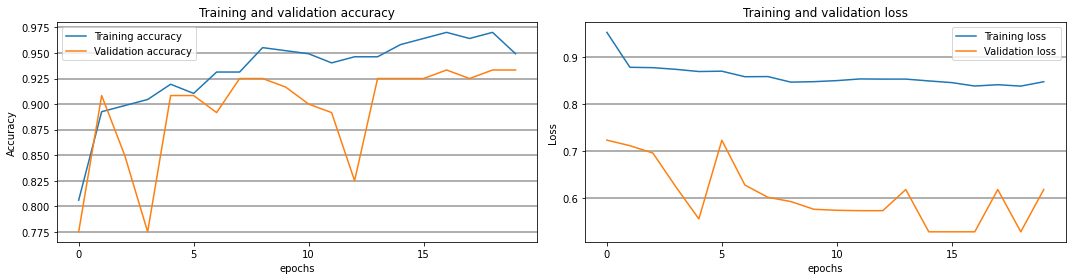

In [ ]:
plot_metrics(hist.history)

In [ ]:
pred = model.predict_generator(val_data_gen, steps=VAL_STEP_PER_EPOCH)
pred = np.argmax(pred, axis=1)
val_lab = val_data_gen.classes
print("Validation labels shape     ===> ", val_lab.shape)
print("Validation prediction shape ===> ", pred.shape)

Validation labels shape     ===>  (120,)
Validation prediction shape ===>  (120,)


In [ ]:
report = classification_report(val_lab, pred)
cm = confusion_matrix(val_lab, pred)

print(30*"*", " Classification report ", 30*"*")
print(30*"=", " Resnet_101 ", 30*"=")
print(report)
print(30*"*", " Confusion matrix ", 30*"*")
print(cm)

******************************  Classification report  ******************************
==============================  Resnet_101  ==============================
              precision    recall  f1-score   support

           0       0.80      0.85      0.82        93
           1       0.33      0.26      0.29        27

    accuracy                           0.72       120
   macro avg       0.57      0.55      0.56       120
weighted avg       0.69      0.72      0.70       120

******************************  Confusion matrix  ******************************
[[79 14]
 [20  7]]


In [ ]:
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_2
1 conv1_pad
2 conv1_conv
3 conv1_bn
4 conv1_relu
5 pool1_pad
6 pool1_pool
7 conv2_block1_1_conv
8 conv2_block1_1_bn
9 conv2_block1_1_relu
10 conv2_block1_2_conv
11 conv2_block1_2_bn
12 conv2_block1_2_relu
13 conv2_block1_0_conv
14 conv2_block1_3_conv
15 conv2_block1_0_bn
16 conv2_block1_3_bn
17 conv2_block1_add
18 conv2_block1_out
19 conv2_block2_1_conv
20 conv2_block2_1_bn
21 conv2_block2_1_relu
22 conv2_block2_2_conv
23 conv2_block2_2_bn
24 conv2_block2_2_relu
25 conv2_block2_3_conv
26 conv2_block2_3_bn
27 conv2_block2_add
28 conv2_block2_out
29 conv2_block3_1_conv
30 conv2_block3_1_bn
31 conv2_block3_1_relu
32 conv2_block3_2_conv
33 conv2_block3_2_bn
34 conv2_block3_2_relu
35 conv2_block3_3_conv
36 conv2_block3_3_bn
37 conv2_block3_add
38 conv2_block3_out
39 conv3_block1_1_conv
40 conv3_block1_1_bn
41 conv3_block1_1_relu
42 conv3_block1_2_conv
43 conv3_block1_2_bn
44 conv3_block1_2_relu
45 conv3_block1_0_conv
46 conv3_block1_3_conv
47 conv3_block1_0_bn
48 conv3_block1_3_bn

### Converting Keras model into ONNX


In [4]:
!pip install -U git+https://github.com/microsoft/onnxconverter-common
!pip install -U git+https://github.com/onnx/keras-onnx

  Cloning https://github.com/microsoft/onnxconverter-common to /tmp/pip-req-build-vp1lq22e
  Running command git clone -q https://github.com/microsoft/onnxconverter-common /tmp/pip-req-build-vp1lq22e
     |████████████████████████████████| 7.4MB 7.3MB/s 
  Created wheel for onnxconverter-common: filename=onnxconverter_common-1.7.0-py2.py3-none-any.whl size=65465 sha256=e600ba3a136c61826496eb1987f118e18bf415718d79f66801464df60e652ebc
  Stored in directory: /tmp/pip-ephem-wheel-cache-75vv6iop/wheels/7d/97/c7/8908efff309db78064933e54f2a70427a75ada73b9b19789c3
Successfully built onnxconverter-common
  Cloning https://github.com/onnx/keras-onnx to /tmp/pip-req-build-uhexgn54
  Running command git clone -q https://github.com/onnx/keras-onnx /tmp/pip-req-build-uhexgn54
     |████████████████████████████████| 81kB 4.9MB/s 
  Created wheel for keras2onnx: filename=keras2onnx-1.7.1-cp36-none-any.whl size=97317 sha256=323adf97651e67d90bf30e2e374478c517cf820a0ad4b64eeb4bac315ee49909
  Stored in di

In [5]:
!pip install onnxruntime

     |████████████████████████████████| 3.9MB 9.5MB/s 


In [6]:
import keras2onnx
import onnxruntime

In [9]:
tr_model = load_model(main_dir + "best_resnet101.h5")

In [10]:
onnx_name = main_dir + "resnet101_onnx.onnx"
onnx_model = keras2onnx.convert_keras(tr_model, tr_model.name)
keras2onnx.save_model(onnx_model, onnx_name)


tf executing eager_mode: True
tf.keras model eager_mode: False
The ONNX operator number change on the optimization: 883 -> 350
